# Figure 1: CT feedback and behaviour modulates dLGN responses to movies

In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def get_color_dict(palette_name='colorblind', n=None, color_names=None,
                   add_default_colors=True):
    """
    Returns color map dictionary from seaborn color palettes with hexadecimal triplet values.

    Parameters
    ----------
    palette_name : str
        Name of palette. Possible values are:
        'colorblind', 'deep', 'muted', 'bright', 'pastel', 'dark'
        For more options see seaborn.color_palette() docs.
    n : int
        Number of colors.
        If not None and arg color_names is given, arg n must be equal to len(color_names).
    color_names : list
        List of color names as strings e.g. for the color palette 'colorblind': ['blue',
        'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'lightblue']
        Must have the same length as colors in the color palette.
        If None, color names are set to ['c0', 'c1', 'c2', ...].
    add_default_colors : bool
        Add default colors that are need but that are not part of the color palette such as
        e.g. 'black'.
        If set to False, the color dict will only contain colors of the chosen palette.

    Returns
    -------
    color_dict: dict
         Color name as key and color triplet as value.
    """
    # Import done here to avoid problems for other user who don't have seaborn installed
    import seaborn as sns

    # Get list of sns colors as hexadecimal triplet
    sns_colors_l = sns.color_palette(palette_name).as_hex()
    if n is not None:
        sns_colors_l = sns_colors_l[:n]
    # Define color names if none are given
    if color_names is None:
        color_names = ["c%d" % i for i in range(0, len(sns_colors_l))]
    # Create color dict
    color_dict = dict.fromkeys(color_names)
    for color_name, color in zip(color_names, sns_colors_l):
        color_dict[color_name] = color
    # Add additional colors to palette
    if add_default_colors is True:
        color_dict['black'] = '#000000'

    return color_dict

In [3]:
def plot_fr_scatter(x, y, labels, facecolor, axlims, figsize, plot_pval=True, s=20, marker='.', mark_neurons=None):
    """ Returns figure of firing rate scatter.
    
    Parameters
    ----------
    x: np.array
        x-values
    y: np.array
        y-values
    labels: list
        ['xlabel', ylabel']
    facecolor: str
        Color of markers
    axlims: list
        [min, max] of axis
    figsize: np.array
        (height, width) of figure
        
    Returns
    -------
    fig:
        figure
    ax_dict: dict
        Contains all axis
    """
    # Get p-value
    W, p = scipy.stats.wilcoxon(x, y)
    print('p = {:.2E}'.format(p))
    print('{:.2f} vs. {:.2f} spikes per sec'.format(np.mean(x), np.mean(y)))

    # Initialize figure
    with plt.style.context("matplotlib_config.txt"):
        mosaic = """
        a
        """
        fig, ax_dict = plt.subplot_mosaic(
            mosaic,
            figsize=figsize,
            dpi=200,
            constrained_layout=True,
            #sharex=True,
        )

        txt_kwargs = dict(
            color="black", fontsize="larger"
        )
        ax = ax_dict['a']
        ax.scatter(x, y, facecolor=facecolor, edgecolor='none', alpha=.5, s=s, marker=marker)
        if mark_neurons is not None:
            for idx_neuron in mark_neurons:
                ax.scatter(x[idx_neuron], y[idx_neuron], color='k', s=5, marker='x')
        ax.plot([0, axlims[1]], [0, axlims[1]], color='grey', linestyle='--', zorder=-1)
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.set_xlim(axlims)
        ax.set_ylim(axlims)
        xticks = ax.get_xticks()
        ax.set_xticks(xticks)
        ax.set_yticks(xticks)
        sns.despine(offset=5, trim=False, ax=ax)

        # Add p-value and n
        if plot_pval:
            if p<0.05:
                txt = 'p < 0.05'
            if p<0.01:
                txt = 'p < 0.01'
            if p<0.001:
                txt = 'p < 0.001'
            else:
                f'p = {np.round(p,3)}'
            txt = txt + f'\nn = {len(x)}'
            #txt = (('p < 0.001' if p<0.001 else f'p = {np.round(p,3)}') + '\n' + f'n = {len(x)}')
            ax.text(0, 1, txt, va='top', fontsize=6, transform=ax.transAxes)

        # Plot inset histogram of differences
        ax_ins = inset_axes(ax, width="30%", height="30%", loc=4, borderpad=0.75)
        ax_ins.hist(np.log2(y/x), color=facecolor, alpha=0.5)  # log2 fold change
        ax_ins.patch.set_facecolor('none')
        ax_ins.spines['left'].set_visible(False)
        ax_ins.spines['right'].set_visible(False)
        ax_ins.tick_params(bottom=True, left=False, right=True,
                           labelbottom=True, labelleft=False, labelright=True,
                           length=1.5, pad=1, labelsize=5)
    
    return fig, ax_dict

In [4]:
color_dict = get_color_dict(color_names=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'lightblue'])

## Raw data

Load data:

In [5]:
filename = './data/population_data.h5'
df = pd.read_hdf(filename, "df")

Restrict to one experiment:

In [6]:
# Define experiment to plot
key = {'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 1}

# DF experiment
df_e = df[(df['m']==key['m']) & (df['s']==key['s']) & (df['e']==key['e'])].reset_index()

Get data:

In [7]:
responses = np.vstack(df_e['response_train'])
run = df_e['run_train'][0]
eye = df_e['eye_train'][0]
opto = df_e['opto_train'][0]

tv = df_e['response_tv'][0] # time vector

Plotting:

In [8]:
# Define plotting range
start_sec = 200
stop_sec = 900

trange = [np.where(tv>start_sec)[0][0], np.where(tv>stop_sec)[0][0]]

x_axis_dur = 50 # sec
#xticks = np.arange(0, trange[1]-trange[0], x_axis_dur/np.mean(np.diff(tv)))
xticks = np.arange(start_sec, stop_sec+1, x_axis_dur)

responses_plot = responses[:, trange[0]:trange[1]]
run_plot = run[trange[0]:trange[1]]
eye_plot = eye[trange[0]:trange[1]]
opto_plot = opto[trange[0]:trange[1]]

tv_plot = tv[trange[0]:trange[1]]
vmin_resp = 0
vmax_resp = 100

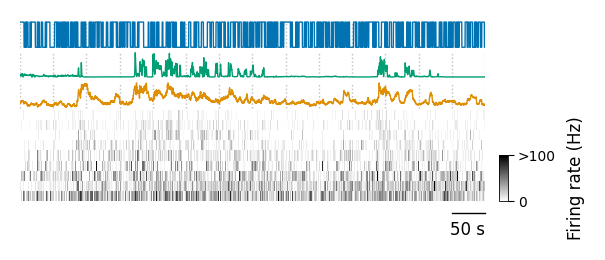

In [110]:
with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    a
    b
    c
    d
    d
    d
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(3, 1.2),
        dpi=200,
        constrained_layout=True,
        #sharex=True,
    )

    txt_kwargs = dict(
        color="black", fontsize="larger"
    )
    
    
    
    # Opto
    ax = ax_dict['a']
    opto_plot = opto[trange[0]:trange[1]]
    ax.plot(tv_plot, opto_plot, color=color_dict['blue'])
    for xtick in xticks:
        ax.vlines(x=xtick, ymin=0, ymax=opto_plot.max(), color='gray', linestyle=':', alpha=.5)
    ax.set_xlim([tv_plot[0],tv_plot[-1]])
    ax.set_ylim([opto_plot.min()-.1, opto_plot.max()+.1])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Running
    ax = ax_dict['b']
    run_plot = run[trange[0]:trange[1]]
    ax.plot(tv_plot, run_plot, color=color_dict['green'])
    for xtick in xticks:
        ax.vlines(x=xtick, ymin=0, ymax=run_plot.max(), color='gray', linestyle=':', alpha=.5)
    ax.set_xlim([tv_plot[0],tv_plot[-1]])
    ax.set_ylim([run_plot.min()-.1, run_plot.max()+.1])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Eye
    ax = ax_dict['c']
    eye_plot = eye[trange[0]:trange[1]]
    ax.plot(tv_plot, eye_plot, color=color_dict['orange'])
    for xtick in xticks:
        ax.vlines(x=xtick, ymin=0, ymax=eye_plot.max(), color='gray', linestyle=':', alpha=.5)
    ax.set_xlim([tv_plot[0],tv_plot[-1]])
    ax.set_ylim([eye_plot.min()-.1, eye_plot.max()+.1])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Responses
    X = responses_plot
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)

    # PCA
    pca = PCA(n_components=4)
    pca.fit(X_standardized)
    X_pca = pca.transform(X_standardized)

    # Sort by PC
    idxs_sorted = np.flip(np.argsort(X_pca[:,0]))
    responses_sorted = X[idxs_sorted[::-1]]

    ax = ax_dict['d']
    im = ax.imshow(responses_sorted, aspect='auto', cmap='gray_r', interpolation='none', vmin=vmin_resp, vmax=vmax_resp)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xlabel(f'{x_axis_dur} s', loc='right', labelpad=7)

    axins = inset_axes(
                    ax,
                    width="2%",  # width: 5% of parent_bbox width
                    height="50%",  # height: 50%
                    loc="center",
                    bbox_to_anchor=(.54, -0.25, 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0,
    )
    cbar = fig.colorbar(im, cax=axins, orientation='vertical', ticks=[vmin_resp, vmax_resp], label='Firing rate (Hz)')
    cbar.ax.tick_params(labelsize=5)
    cbar.set_ticklabels([vmin_resp, f'>{vmax_resp}'])
    
    #ax.set_ylabel('Neurons\n10', ma='left', labelpad=0)

    sns.despine(bottom=True, left=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    # x axis
    ax_dict['c'].spines['bottom'].set_visible(True)
    ax_dict['c'].spines['bottom'].set_bounds([stop_sec-x_axis_dur, stop_sec])
    ax_dict['c'].spines['bottom'].set_linewidth(.5)
    ax_dict['c'].spines['bottom'].set_position(('outward', 37))
    
fig.savefig('./plots/Fig1/raw_data_sorted_by_PC1.svg', bbox_inches='tight')
fig.savefig('./plots/Fig1/raw_data_sorted_by_PC1.png', bbox_inches='tight', dpi=500)

In [111]:
f'number of neurons = {responses_sorted.shape[0]}'

'number of neurons = 9'

### Different experiment

In [98]:
# Define experiment to plot
key = {'m': 'Ntsr1Cre_2019_0008', 's': 7, 'e': 6, 'u': 1}

# DF experiment
df_e = df[(df['m']==key['m']) & (df['s']==key['s']) & (df['e']==key['e'])].reset_index()

Get data:

In [99]:
responses = np.vstack(df_e['response_train'])
run = df_e['run_train'][0]
eye = df_e['eye_train'][0]
opto = df_e['opto_train'][0]

tv = df_e['response_tv'][0] # time vector

Plotting:

In [102]:
# Define plotting range
start_sec = 0
stop_sec = 900

trange = [np.where(tv>start_sec)[0][0], np.where(tv>stop_sec)[0][0]]

x_axis_dur = 50 # sec
#xticks = np.arange(0, trange[1]-trange[0], x_axis_dur/np.mean(np.diff(tv)))
xticks = np.arange(start_sec, stop_sec+1, x_axis_dur)

responses_plot = responses[:, trange[0]:trange[1]]
run_plot = run[trange[0]:trange[1]]
eye_plot = eye[trange[0]:trange[1]]
opto_plot = opto[trange[0]:trange[1]]

tv_plot = tv[trange[0]:trange[1]]
vmin_resp = 0
vmax_resp = 80

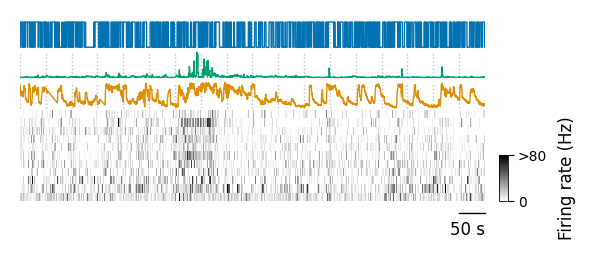

In [103]:
with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    a
    b
    c
    d
    d
    d
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(3, 1.2),
        dpi=200,
        constrained_layout=True,
        #sharex=True,
    )

    txt_kwargs = dict(
        color="black", fontsize="larger"
    )
    
    
    
    # Opto
    ax = ax_dict['a']
    opto_plot = opto[trange[0]:trange[1]]
    ax.plot(tv_plot, opto_plot, color=color_dict['blue'])
    for xtick in xticks:
        ax.vlines(x=xtick, ymin=0, ymax=opto_plot.max(), color='gray', linestyle=':', alpha=.5)
    ax.set_xlim([tv_plot[0],tv_plot[-1]])
    ax.set_ylim([opto_plot.min()-.1, opto_plot.max()+.1])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Running
    ax = ax_dict['b']
    run_plot = run[trange[0]:trange[1]]
    ax.plot(tv_plot, run_plot, color=color_dict['green'])
    for xtick in xticks:
        ax.vlines(x=xtick, ymin=0, ymax=run_plot.max(), color='gray', linestyle=':', alpha=.5)
    ax.set_xlim([tv_plot[0],tv_plot[-1]])
    ax.set_ylim([run_plot.min()-.1, run_plot.max()+.1])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Eye
    ax = ax_dict['c']
    eye_plot = eye[trange[0]:trange[1]]
    ax.plot(tv_plot, eye_plot, color=color_dict['orange'])
    for xtick in xticks:
        ax.vlines(x=xtick, ymin=0, ymax=eye_plot.max(), color='gray', linestyle=':', alpha=.5)
    ax.set_xlim([tv_plot[0],tv_plot[-1]])
    ax.set_ylim([eye_plot.min()-.1, eye_plot.max()+.1])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Responses
    X = responses_plot
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)

    # PCA
    pca = PCA(n_components=4)
    pca.fit(X_standardized)
    X_pca = pca.transform(X_standardized)

    # Sort by PC
    idxs_sorted = np.flip(np.argsort(X_pca[:,0]))
    responses_sorted = X[idxs_sorted[::-1]]

    ax = ax_dict['d']
    im = ax.imshow(responses_sorted, aspect='auto', cmap='gray_r', interpolation='none', vmin=vmin_resp, vmax=vmax_resp)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xlabel(f'{x_axis_dur} s', loc='right', labelpad=7)

    axins = inset_axes(
                    ax,
                    width="2%",  # width: 5% of parent_bbox width
                    height="50%",  # height: 50%
                    loc="center",
                    bbox_to_anchor=(.54, -0.25, 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0,
    )
    cbar = fig.colorbar(im, cax=axins, orientation='vertical', ticks=[vmin_resp, vmax_resp], label='Firing rate (Hz)')
    cbar.ax.tick_params(labelsize=5)
    cbar.set_ticklabels([vmin_resp, f'>{vmax_resp}'])
    
    #ax.set_ylabel('Neurons\n10', ma='left', labelpad=0)

    sns.despine(bottom=True, left=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    # x axis
    ax_dict['c'].spines['bottom'].set_visible(True)
    ax_dict['c'].spines['bottom'].set_bounds([stop_sec-x_axis_dur, stop_sec])
    ax_dict['c'].spines['bottom'].set_linewidth(.5)
    ax_dict['c'].spines['bottom'].set_position(('outward', 37))
    
fig.savefig('./plots/Fig1/raw_data_sorted_by_PC1_.svg', bbox_inches='tight')
fig.savefig('./plots/Fig1/raw_data_sorted_by_PC1_.png', bbox_inches='tight', dpi=500)

In [105]:
f'number of neurons = {responses_sorted.shape[0]}'

'number of neurons = 11'

## Example opto unit

In [9]:
key = {'m': 'Ntsr1Cre_2019_0008', 's': 5, 'e': 8, 'u': 19}
#key = {'m': 'Ntsr1Cre_2019_0008', 's': 3, 'e': 7, 'u': 22}

In [10]:
filename = './data/{:s}_s{:02d}_e{:02d}_u{:02d}.h5'.format(key['m'], key['s'], key['e'], key['u'])
df = pd.read_hdf(filename, "df")

In [11]:
df.columns

Index(['strf', 'srf', 'trf', 'stim_width_deg', 'stim_height_deg',
       'stim_x_center', 'stim_y_center', 'filt_opto', 'filt_run', 'filt_eye',
       'y_train', 'yhat_train', 'y_test', 'yhat_test', 'r_train', 'r_test',
       'rf_x_pos_deg', 'rf_y_pos_deg', 'perm_score_true', 'perm_score_stim',
       'perm_score_opto', 'perm_score_run', 'perm_score_eye',
       'perm_score_true_mean', 'perm_score_stim_mean', 'perm_score_opto_mean',
       'perm_score_run_mean', 'perm_score_eye_mean', 'opto_rasters',
       'opto_psths', 'opto_midbins', 'ctrl_rasters', 'ctrl_psths',
       'ctrl_midbins', 'paramsets'],
      dtype='object')

In [12]:
midbins_ctrl = df['ctrl_midbins'].values[0]
rasters_ctrl = df['ctrl_rasters'].values[0]
psths_ctrl = df['ctrl_psths'].values[0]

midbins_opto = df['opto_midbins'].values[0]
rasters_opto = df['opto_rasters'].values[0]
psths_opto = df['opto_psths'].values[0]

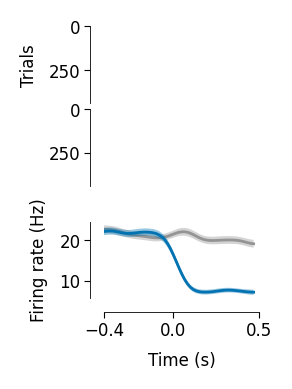

In [13]:
marker_type='|'
marker_size=.01
offsets=[np.round(midbins_opto[0], 1), -np.round(midbins_opto[-1], 1)]

psth_opto_mean = np.mean(psths_opto, axis=0)
psth_opto_err = scipy.stats.sem(psths_opto, axis=0)

psth_ctrl_mean = np.mean(psths_ctrl, axis=0)
psth_ctrl_err = scipy.stats.sem(psths_ctrl, axis=0)

with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    a
    b
    c
    d
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(1, 1.8),
        dpi=200,
        constrained_layout=True,
        gridspec_kw={"height_ratios":[1, 1, .3, 1]},
    )
    
    txt_kwargs = dict(
        color="black", fontsize="larger"
    )

    # Delete placeholder plot
    ax = ax_dict['c']
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Spike raster plot control trials
    ax = ax_dict['a']
    for i in range(len(rasters_ctrl)):
        y=np.ones((rasters_ctrl[i].shape[0],))*i
        ax.scatter(rasters_ctrl[i], y, c=color_dict['gray'], marker=marker_type, s=marker_size, alpha=1)
        ax.set_xlim([offsets[0], 1+offsets[1]])
        ax.set_ylim([0, rasters_ctrl.shape[0]])
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.invert_yaxis()
        ax.set_ylabel('Trials')
        
    # Spike raster plot opto trials
    ax = ax_dict['b']
    for i in range(len(rasters_opto)):
        y=np.ones((rasters_opto[i].shape[0],))*i
        ax.scatter(rasters_opto[i], y, c=color_dict['blue'], marker=marker_type, s=marker_size, alpha=1)
        ax.set_xlim([offsets[0], 1+offsets[1]])
        ax.set_ylim([0, rasters_opto.shape[0]])
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.invert_yaxis()
        
    # PSTH
    ax = ax_dict['d']
    ax.plot(midbins_ctrl, psth_ctrl_mean, 
            c=color_dict['gray'], 
            lw=1,
            zorder=1, 
            label='Control')
    ax.fill_between(midbins_ctrl, psth_ctrl_mean-psth_ctrl_err, psth_ctrl_mean+psth_ctrl_err,
                    fc=color_dict['gray'], 
                    ec="none", 
                    alpha=0.4,
                    zorder=1)
    ax.plot(midbins_opto, psth_opto_mean, 
            c=color_dict['blue'], 
            lw=1,
            zorder=2, 
            label='CT FB supp')
    ax.fill_between(midbins_opto, psth_opto_mean-psth_opto_err, psth_opto_mean+psth_opto_err,
                    fc=color_dict['blue'], 
                    ec="none", 
                    alpha=0.4,
                    zorder=2)
    #ax.legend(loc='upper center', ncol=1, frameon=False, bbox_to_anchor=[.5,1.6])
    ax.set_xlim([offsets[0], 1+offsets[1]])
    ax.set_xticks([offsets[0], 0, 1+offsets[1]])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Firing rate (Hz)')
    
    # Formatting
    sns.despine(offset=5, trim=False)
    ax_dict['a'].spines['bottom'].set_visible(False)
    ax_dict['b'].spines['bottom'].set_visible(False)
    ax_dict['c'].spines['bottom'].set_visible(False)
    ax_dict['c'].spines['left'].set_visible(False)
    
    plt.subplots_adjust(hspace=0.1)
    
fig.savefig('./plots/Fig1/{:s}_s{:02d}_e{:02d}_u{:02d}_opto_raster_psth.svg'.format(key['m'], key['s'], key['e'], key['u']))
fig.savefig('./plots/Fig1/{:s}_s{:02d}_e{:02d}_u{:02d}_opto_raster_psth.png'.format(key['m'], key['s'], key['e'], key['u']))

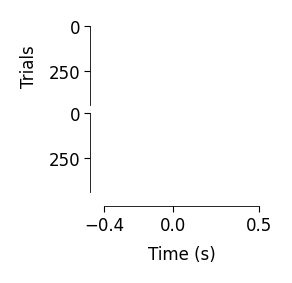

In [17]:
marker_type='|'
marker_size=.01
offsets=[np.round(midbins_opto[0], 1), -np.round(midbins_opto[-1], 1)]

psth_opto_mean = np.mean(psths_opto, axis=0)
psth_opto_err = scipy.stats.sem(psths_opto, axis=0)

psth_ctrl_mean = np.mean(psths_ctrl, axis=0)
psth_ctrl_err = scipy.stats.sem(psths_ctrl, axis=0)

with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    a
    b
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(1, 1.1),
        dpi=200,
        constrained_layout=True,
    )
    
    txt_kwargs = dict(
        color="black", fontsize="larger"
    )
    
    # Spike raster plot control trials
    ax = ax_dict['a']
    for i in range(len(rasters_ctrl)):
        y=np.ones((rasters_ctrl[i].shape[0],))*i
        ax.scatter(rasters_ctrl[i], y, c=color_dict['gray'], marker=marker_type, s=marker_size, alpha=1)
        ax.set_xlim([offsets[0], 1+offsets[1]])
        ax.set_ylim([0, rasters_ctrl.shape[0]])
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.invert_yaxis()
        ax.set_ylabel('Trials')
        
    # Spike raster plot opto trials
    ax = ax_dict['b']
    for i in range(len(rasters_opto)):
        y=np.ones((rasters_opto[i].shape[0],))*i
        ax.scatter(rasters_opto[i], y, c=color_dict['blue'], marker=marker_type, s=marker_size, alpha=1)
    ax.set_ylim([0, rasters_opto.shape[0]])
    ax.invert_yaxis()
    ax.set_xlim([offsets[0], 1+offsets[1]])
    ax.set_xticks([offsets[0], 0, 1+offsets[1]])
    ax.set_xlabel('Time (s)')

    
    # Formatting
    sns.despine(offset=5, trim=False)
    ax_dict['a'].spines['bottom'].set_visible(False)
    #ax_dict['b'].spines['bottom'].set_visible(False)
    
    plt.subplots_adjust(hspace=0.1)
    
fig.savefig('./plots/Fig1/{:s}_s{:02d}_e{:02d}_u{:02d}_opto_raster.svg'.format(key['m'], key['s'], key['e'], key['u']))
fig.savefig('./plots/Fig1/{:s}_s{:02d}_e{:02d}_u{:02d}_opto_raster.png'.format(key['m'], key['s'], key['e'], key['u']))

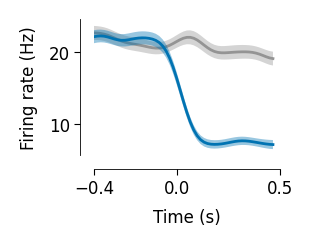

In [14]:
marker_type='|'
marker_size=.01
offsets=[np.round(midbins_opto[0], 1), -np.round(midbins_opto[-1], 1)]

psth_opto_mean = np.mean(psths_opto, axis=0)
psth_opto_err = scipy.stats.sem(psths_opto, axis=0)

psth_ctrl_mean = np.mean(psths_ctrl, axis=0)
psth_ctrl_err = scipy.stats.sem(psths_ctrl, axis=0)

with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    a
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(1.2, .9),
        dpi=200,
        constrained_layout=True,
    )
    
    txt_kwargs = dict(
        color="black", fontsize="larger"
    )
        
    # PSTH
    ax = ax_dict['a']
    ax.plot(midbins_ctrl, psth_ctrl_mean, 
            c=color_dict['gray'], 
            lw=1,
            zorder=1, 
            label='Control')
    ax.fill_between(midbins_ctrl, psth_ctrl_mean-psth_ctrl_err, psth_ctrl_mean+psth_ctrl_err,
                    fc=color_dict['gray'], 
                    ec="none", 
                    alpha=0.4,
                    zorder=1)
    ax.plot(midbins_opto, psth_opto_mean, 
            c=color_dict['blue'], 
            lw=1,
            zorder=2, 
            label='CT FB supp')
    ax.fill_between(midbins_opto, psth_opto_mean-psth_opto_err, psth_opto_mean+psth_opto_err,
                    fc=color_dict['blue'], 
                    ec="none", 
                    alpha=0.4,
                    zorder=2)
    #ax.legend(loc='upper center', ncol=1, frameon=False, bbox_to_anchor=[.5,1.6])
    ax.set_xlim([offsets[0], 1+offsets[1]])
    ax.set_xticks([offsets[0], 0, 1+offsets[1]])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Firing rate (Hz)')
    
    # Formatting
    sns.despine(offset=5, trim=False)
    
    plt.subplots_adjust(hspace=0.1)
    
fig.savefig('./plots/Fig1/{:s}_s{:02d}_e{:02d}_u{:02d}_opto_psth.svg'.format(key['m'], key['s'], key['e'], key['u']))
fig.savefig('./plots/Fig1/{:s}_s{:02d}_e{:02d}_u{:02d}_opto_psth.png'.format(key['m'], key['s'], key['e'], key['u']))

# Firing rate scatters

Load data:

In [5]:
filename = './data/population_data.h5'
df = pd.read_hdf(filename, "df")

In [6]:
df.columns

Index(['m', 's', 'e', 'u', 'paramset', 'fr_mean_e', 'fr_mean_stim',
       'fr_mean_spont_ctrl', 'fr_opto', 'fr_ctrl', 'fr_var_opto',
       'fr_var_ctrl', 'fr_run', 'fr_sit', 'fr_pupil_large', 'fr_pupil_small',
       'sparseness', 'reliability', 'omi_e', 'omi', 'omi_spont', 'rmi', 'emi',
       'response_train', 'response_tv', 'opto_train', 'run_train', 'eye_train',
       'strf', 'srf', 'trf', 'srf_val', 'filt_opto', 'filt_run', 'filt_eye',
       'perm_score_true', 'perm_score_stim', 'perm_score_opto',
       'perm_score_run', 'perm_score_eye', 'perm_score_true_mean',
       'perm_score_stim_mean', 'perm_score_opto_mean', 'perm_score_run_mean',
       'perm_score_eye_mean', 'perm_pvalue_stim', 'perm_pvalue_opto',
       'perm_pvalue_run', 'perm_pvalue_eye'],
      dtype='object')

## CT FB suppression

p = 1.24E-02
12.26 vs. 11.50 spikes per sec


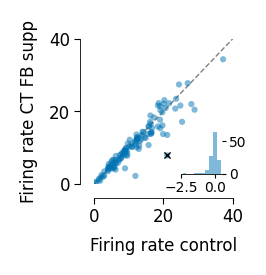

In [16]:
fr_ctrl = df['fr_ctrl']
fr_opto = df['fr_opto']
idx_exmpl_neuron = np.where((df['m']==key['m']) & (df['s']==key['s']) & (df['e']==key['e']) & (df['u']==key['u']) )[0][0]

fig, ax_dict = plot_fr_scatter(x=fr_ctrl, 
                               y=fr_opto, 
                               labels=['Firing rate control', 'Firing rate CT FB supp'], 
                               facecolor=color_dict['blue'], 
                               axlims=[0,40], 
                               figsize=(1.2, 1.2),
                               plot_pval=False,
                               mark_neurons=[idx_exmpl_neuron])

fig.savefig('./plots/Fig1/fr_scatter_opto_smaller.svg')

p = 0.0064


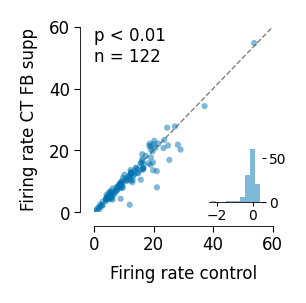

In [54]:
fr_ctrl = df['fr_ctrl']
fr_opto = df['fr_opto']

fig, ax_dict = plot_fr_scatter(x=fr_ctrl, 
                               y=fr_opto, 
                               labels=['Firing rate control', 'Firing rate CT FB supp'], 
                               facecolor=color_dict['blue'], 
                               axlims=[0,60], 
                               figsize=(1.4, 1.4),
                              )#(1.1, 1.1))

fig.savefig('./plots/Fig1/fr_scatter_opto_smaller_full.svg')

## Running

p = 8.31E-16
11.02 vs. 12.87 spikes per sec


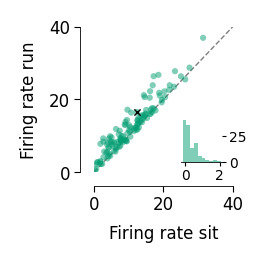

In [17]:
fr_run = df['fr_run']
fr_sit = df['fr_sit']

fig, ax_dict = plot_fr_scatter(x=fr_sit, 
                               y=fr_run, 
                               labels=['Firing rate sit', 'Firing rate run'], 
                               facecolor=color_dict['green'], 
                               axlims=[0,40], 
                               figsize=(1.2, 1.2),
                               plot_pval=False,
                               mark_neurons=[idx_exmpl_neuron])#(1.1, 1.1))

fig.savefig('./plots/Fig1/fr_scatter_run_smaller.svg')

p = 0.0000


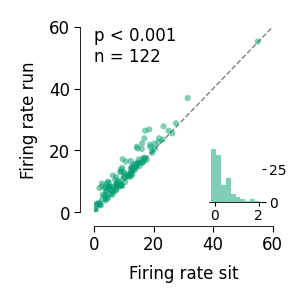

In [56]:
fr_run = df['fr_run']
fr_sit = df['fr_sit']

fig, ax_dict = plot_fr_scatter(x=fr_sit, 
                               y=fr_run, 
                               labels=['Firing rate sit', 'Firing rate run'], 
                               facecolor=color_dict['green'], 
                               axlims=[0,60], 
                               figsize=(1.4, 1.4))#(1.1, 1.1))

fig.savefig('./plots/Fig1/fr_scatter_run_smaller_full.svg')

## Pupil size 

p = 4.98E-07
11.03 vs. 13.00 spikes per sec


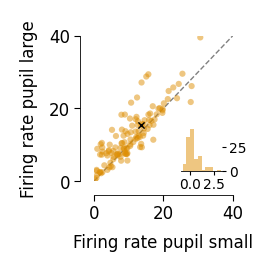

In [18]:
pupil_large = df['fr_pupil_large']
pupil_small = df['fr_pupil_small']

fig, ax_dict = plot_fr_scatter(x=pupil_small, 
                               y=pupil_large, 
                               labels=['Firing rate pupil small', 'Firing rate pupil large'], 
                               facecolor=color_dict['orange'], 
                               axlims=[0,40], 
                               figsize=(1.2, 1.2),
                               plot_pval=False,
                               mark_neurons=[idx_exmpl_neuron])#(1.1, 1.1))

fig.savefig('./plots/Fig1/fr_scatter_pupil_smaller.svg')

p = 0.0000


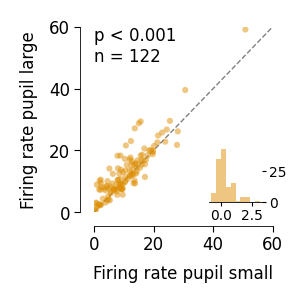

In [58]:
pupil_large = df['fr_pupil_large']
pupil_small = df['fr_pupil_small']

fig, ax_dict = plot_fr_scatter(x=pupil_small, 
                               y=pupil_large, 
                               labels=['Firing rate pupil small', 'Firing rate pupil large'], 
                               facecolor=color_dict['orange'], 
                               axlims=[0,60], 
                               figsize=(1.4, 1.4))#(1.1, 1.1))

fig.savefig('./plots/Fig1/fr_scatter_pupil_smaller_full.svg')

# Supplementary Figure

* correlation matrix of predictors
* spike raster and PSTH for eye & run